In [ ]:
import os

base_path = "/kaggle/input/breast-cancer-classification/all_images"

# Check total images
files = os.listdir(base_path)
print("Total images:", len(files))

# Check a few sample names
print("First 10 files:", files[:10])

# Check how many belong to each class (Benign/Malignant)
benign = [f for f in files if "_B_" in f]
malignant = [f for f in files if "_M_" in f]

print(f"Benign images: {len(benign)}")
print(f"Malignant images: {len(malignant)}")


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

base_path = "/kaggle/input/breast-cancer-classification/all_images"

# Load images and labels
images = []
labels = []

for file in os.listdir(base_path):
    path = os.path.join(base_path, file)
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))  # resize to smaller shape for faster training
    img = img / 255.0  # normalize
    images.append(img)
    label = 0 if "_B_" in file else 1  # 0=Benign, 1=Malignant
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)
print("Example labels:", labels[:10])


In [ ]:
# ===============================================
# STEP 0 — Setup and Imports
# ===============================================
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16, DenseNet121, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# ===============================================
# STEP 1 — Load and Balance Dataset
# ===============================================
data_dir = "/kaggle/input/breast-cancer-classification/all_images"
all_images = os.listdir(data_dir)

# Extract class info from filenames (M = malignant, B = benign)
benign_images = [f for f in all_images if "_B_" in f]
malignant_images = [f for f in all_images if "_M_" in f]

# Make both classes equal in count
min_class = min(len(benign_images), len(malignant_images))
benign_images = random.sample(benign_images, min_class)
malignant_images = random.sample(malignant_images, min_class)

# Further reduce to around 3000 total images (1500 each)
target_per_class = min(1500, min_class)
benign_images = random.sample(benign_images, target_per_class)
malignant_images = random.sample(malignant_images, target_per_class)

print(f"Benign images: {len(benign_images)}")
print(f"Malignant images: {len(malignant_images)}")

image_paths = [os.path.join(data_dir, f) for f in benign_images + malignant_images]
labels = [0]*len(benign_images) + [1]*len(malignant_images)

# ===============================================
# STEP 2 — Load and Resize Images
# ===============================================
def load_images(image_paths, size):
    imgs = []
    for p in tqdm(image_paths, desc=f"Resizing to {size}"):
        img = load_img(p, target_size=(size, size))
        img = img_to_array(img) / 255.0
        imgs.append(img)
    return np.array(imgs)

X_224 = load_images(image_paths, 224)
X_299 = load_images(image_paths, 299)
y = np.array(labels)

# Train-test split
X_train_224, X_test_224, y_train, y_test = train_test_split(X_224, y, test_size=0.2, stratify=y, random_state=42)
X_train_299, X_test_299, _, _ = train_test_split(X_299, y, test_size=0.2, stratify=y, random_state=42)

y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

print("Training data shape:", X_train_224.shape)
print("Test data shape:", X_test_224.shape)

# ===============================================
# STEP 3 — Build Model Functions
# ===============================================
def build_vgg():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_dense():
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_xcep():
    base = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ===============================================
# STEP 4 — Train Each Model
# ===============================================
vgg_model = build_vgg()
dense_model = build_dense()
xcep_model = build_xcep()

print("\nTraining VGG16...")
vgg_model.fit(X_train_224, y_train_cat, validation_data=(X_test_224, y_test_cat), epochs=3, batch_size=16, verbose=1)

print("\nTraining DenseNet121...")
dense_model.fit(X_train_224, y_train_cat, validation_data=(X_test_224, y_test_cat), epochs=3, batch_size=16, verbose=1)

print("\nTraining Xception...")
xcep_model.fit(X_train_299, y_train_cat, validation_data=(X_test_299, y_test_cat), epochs=3, batch_size=16, verbose=1)

# ===============================================
# STEP 5 — Soft Voting Ensemble
# ===============================================
print("\nEvaluating Soft Voting Ensemble...")

pred_vgg = vgg_model.predict(X_test_224)
pred_dense = dense_model.predict(X_test_224)
pred_xcep = xcep_model.predict(X_test_299)

# Average probabilities
ensemble_pred = (pred_vgg + pred_dense + pred_xcep) / 3
final_labels = np.argmax(ensemble_pred, axis=1)

acc = accuracy_score(y_test, final_labels)
print(f"\n✅ Ensemble Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_labels, target_names=['Benign','Malignant']))

# ===============================================
# STEP 6 — Visualization
# ===============================================
plt.figure(figsize=(5,5))
plt.bar(['VGG16', 'DenseNet', 'Xception', 'Ensemble'], [
    accuracy_score(y_test, np.argmax(pred_vgg, axis=1)),
    accuracy_score(y_test, np.argmax(pred_dense, axis=1)),
    accuracy_score(y_test, np.argmax(pred_xcep, axis=1)),
    acc
])
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()


In [1]:
import sklearn, scikeras
print("scikit-learn:", sklearn.__version__)
print("scikeras:", scikeras.__version__)


2025-10-31 04:16:38.597824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761884198.622411     173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761884198.630123     173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


scikit-learn: 1.3.2
scikeras: 0.12.0


In [ ]:

import os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16, DenseNet121, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# =========================================================
# STEP 1 — Load and Balance Dataset
# =========================================================
data_dir = "/kaggle/input/breast-cancer-classification/all_images"
all_images = os.listdir(data_dir)

benign_images = [f for f in all_images if "_B_" in f]
malignant_images = [f for f in all_images if "_M_" in f]

# Balance the dataset
min_class = min(len(benign_images), len(malignant_images))
benign_images = random.sample(benign_images, min_class)
malignant_images = random.sample(malignant_images, min_class)

# Further limit to ~3000 total images
target_per_class = min(1500, min_class)
benign_images = random.sample(benign_images, target_per_class)
malignant_images = random.sample(malignant_images, target_per_class)

print(f"Benign: {len(benign_images)} | Malignant: {len(malignant_images)}")

image_paths = [os.path.join(data_dir, f) for f in benign_images + malignant_images]
labels = [0]*len(benign_images) + [1]*len(malignant_images)

# =========================================================
# STEP 2 — Preprocessing
# =========================================================
def load_images(image_paths, size):
    imgs = []
    for p in tqdm(image_paths, desc=f"Loading {size}x{size}"):
        img = load_img(p, target_size=(size, size))
        img = img_to_array(img) / 255.0
        imgs.append(img)
    return np.array(imgs)

# For simplicity, all models use 224×224 (Xception can handle it fine)
X = load_images(image_paths, 224)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



Training VGG16...
Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 301ms/step - binary_accuracy: 0.5796 - loss: 0.6908
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - binary_accuracy: 0.7963 - loss: 0.4829
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 291ms/step - binary_accuracy: 0.8159 - loss: 0.4486

Training DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 206s 169ms/step - binary_accuracy: 0.7712 - loss: 0.4489
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - binary_accuracy: 0.9560 - loss: 0.1317
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - binary_accuracy: 0.9776 - loss: 0.0621

Training Xception...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3


E0000 00:00:1761886182.840865     225 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761886182.999155     225 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761886183.847639     225 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761886183.984112     225 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


150/150 ━━━━━━━━━━━━━━━━━━━━ 102s 281ms/step - binary_accuracy: 0.7311 - loss: 0.5029
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - binary_accuracy: 0.9553 - loss: 0.1245
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - binary_accuracy: 0.9754 - loss: 0.0774

Performing soft voting...
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 784ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step   
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 637ms/step

✅ Soft Voting Ensemble Accuracy: 0.9533

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.96      0.95       300
   Malignant       0.96      0.95      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



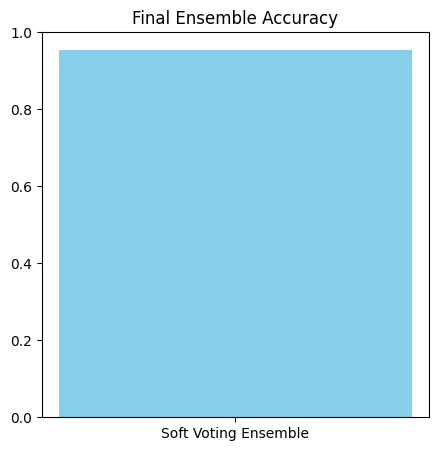

In [6]:
# =========================================================
# STEP 3 — Model Builders
# =========================================================
def build_vgg():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

def build_dense():
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

def build_xcep():
    base = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model


# =========================================================
# STEP 4 — Train each model individually (GPU-enabled)
# =========================================================
print("\nTraining VGG16...")
vgg = build_vgg()
vgg.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)

print("\nTraining DenseNet121...")
dense = build_dense()
dense.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)

print("\nTraining Xception...")
xcep = build_xcep()
xcep.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)


# =========================================================
# STEP 5 — Soft Voting Ensemble (Manual)
# =========================================================
print("\nPerforming soft voting...")

# Get probabilities
pred_vgg = vgg.predict(X_test)
pred_dense = dense.predict(X_test)
pred_xcep = xcep.predict(X_test)

# Average predictions (soft voting)
avg_pred = (pred_vgg + pred_dense + pred_xcep) / 3.0

# Convert probabilities to final binary output
final_pred = (avg_pred > 0.5).astype(int)

# =========================================================
# STEP 6 — Evaluate
# =========================================================
acc = accuracy_score(y_test, final_pred)
print(f"\n✅ Soft Voting Ensemble Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_pred, target_names=['Benign', 'Malignant']))

# =========================================================
# STEP 7 — Plot Accuracy
# =========================================================
plt.figure(figsize=(5,5))
plt.bar(['Soft Voting Ensemble'], [acc], color='skyblue')
plt.title("Final Ensemble Accuracy")
plt.ylim(0,1)
plt.show()


<Figure size 500x500 with 0 Axes>

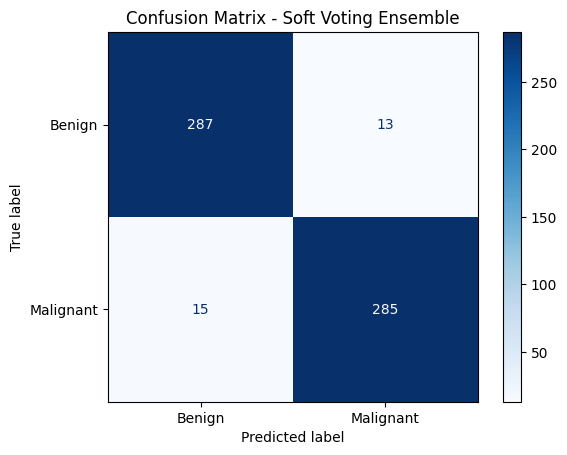

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, final_pred)

# Plot it
plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Soft Voting Ensemble")
plt.show()


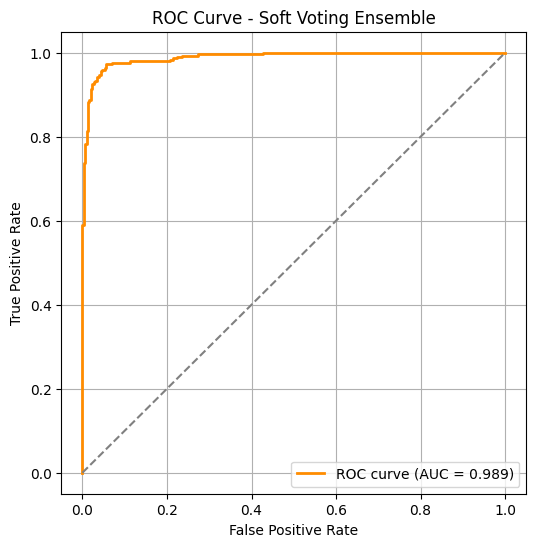

In [12]:
from sklearn.metrics import roc_curve, auc

# Use averaged probability for ROC
fpr, tpr, _ = roc_curve(y_test, avg_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Soft Voting Ensemble')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


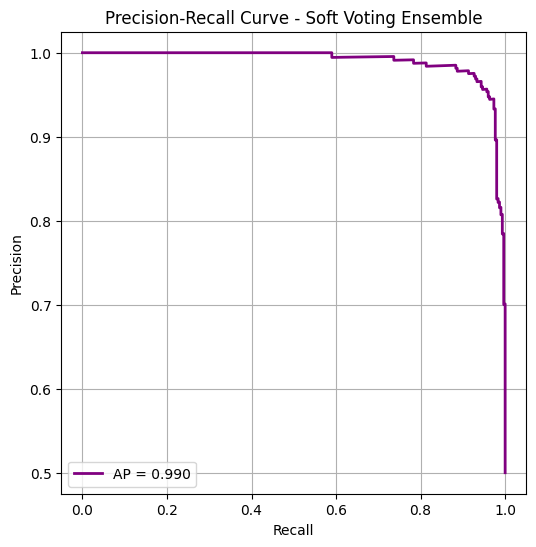

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, avg_pred)
ap = average_precision_score(y_test, avg_pred)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Soft Voting Ensemble')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


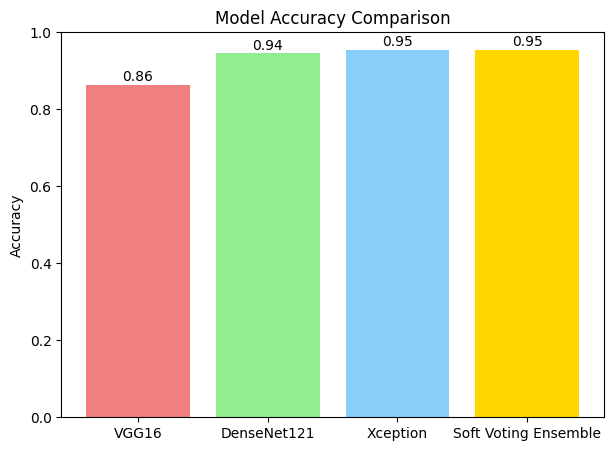

In [14]:
# Example individual model accuracies (replace with your actual results)
acc_vgg = vgg.evaluate(X_test, y_test, verbose=0)[1]
acc_dense = dense.evaluate(X_test, y_test, verbose=0)[1]
acc_xcep = xcep.evaluate(X_test, y_test, verbose=0)[1]

models = ['VGG16', 'DenseNet121', 'Xception', 'Soft Voting Ensemble']
accuracies = [acc_vgg, acc_dense, acc_xcep, acc]

plt.figure(figsize=(7,5))
plt.bar(models, accuracies, color=['lightcoral', 'lightgreen', 'lightskyblue', 'gold'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()


In [17]:
import pandas as pd

report = classification_report(y_test, final_pred, target_names=['Benign', 'Malignant'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)


,precision,recall,f1-score,support
Benign,0.950331,0.956667,0.953488,300.000000
Malignant,0.956376,0.950000,0.953177,300.000000
accuracy,0.953333,0.953333,0.953333,0.953333
macro avg,0.953353,0.953333,0.953333,600.000000
weighted avg,0.953353,0.953333,0.953333,600.000000


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_88']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipykernel_173/2938979211.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_110']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_540']]
Received: inputs=Tensor(

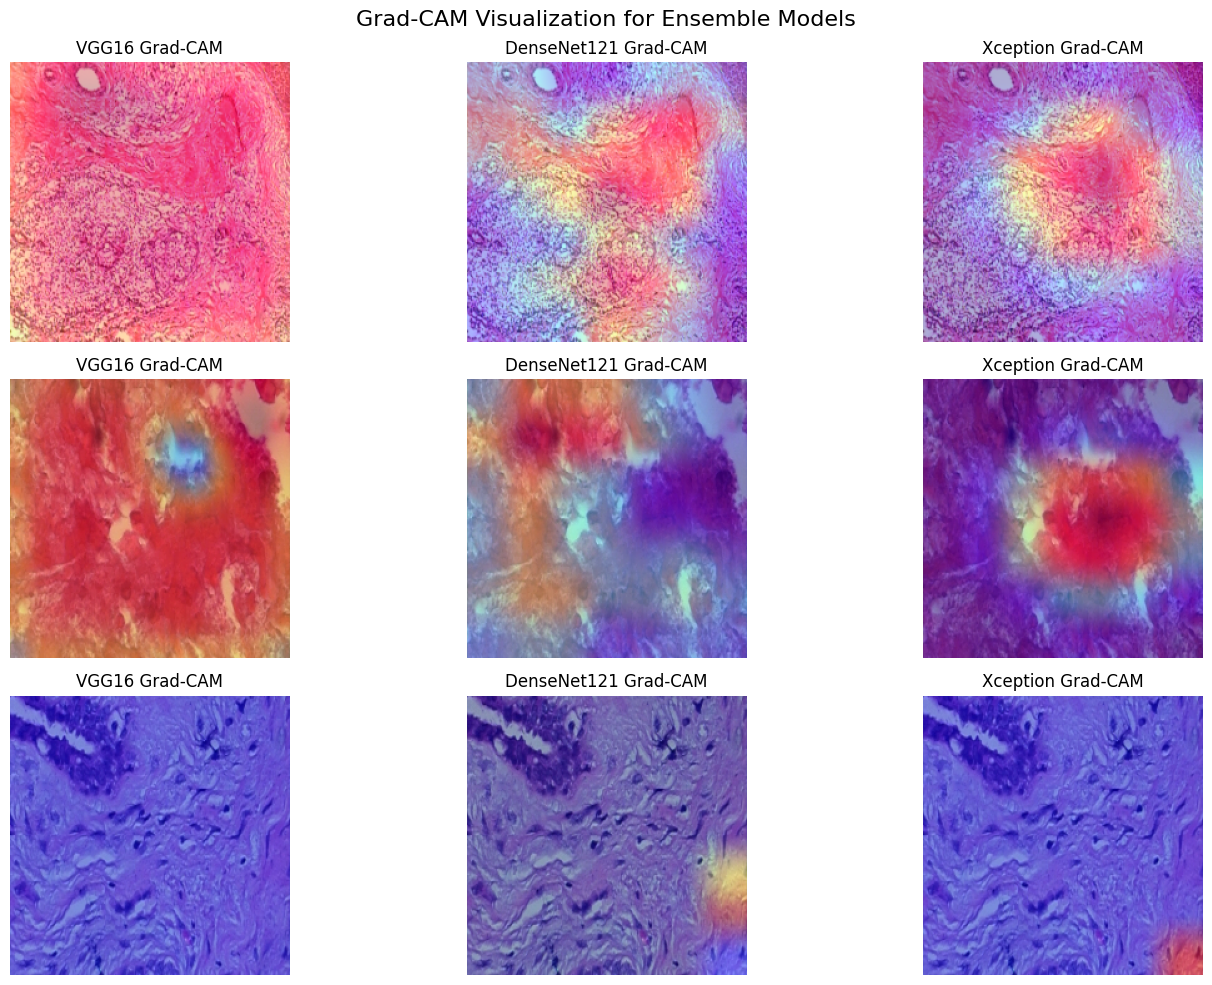

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
import cv2

# =========================================================
# Grad-CAM Function
# =========================================================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Average gradients over all pixels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight the channels by corresponding gradients
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# =========================================================
# Visualization Helper
# =========================================================
def display_gradcam(img, heatmap, alpha=0.4):
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose heatmap on image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    return superimposed_img

# =========================================================
# Pick a few test samples
# =========================================================
indices = np.random.choice(len(X_test), 3, replace=False)
models = [
    ("VGG16", vgg, "block5_conv3"),
    ("DenseNet121", dense, "conv5_block16_concat"),
    ("Xception", xcep, "block14_sepconv2_act")
]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    img = X_test[idx]
    img_array = np.expand_dims(img, axis=0)

    for j, (name, model, last_layer) in enumerate(models):
        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_layer)
        superimposed_img = display_gradcam((img * 255).astype("uint8"), heatmap)

        plt.subplot(len(indices), len(models), i * len(models) + j + 1)
        plt.imshow(superimposed_img)
        plt.axis("off")
        plt.title(f"{name} Grad-CAM")
plt.suptitle("Grad-CAM Visualization for Ensemble Models", fontsize=16)
plt.tight_layout()
plt.show()


In [20]:
# =========================================================
# STEP 6A — Compute Training Accuracy for Soft Voting
# =========================================================
print("\nEvaluating soft voting ensemble on training data...")

# Get training predictions for each model
train_pred_vgg = vgg.predict(X_train)
train_pred_dense = dense.predict(X_train)
train_pred_xcep = xcep.predict(X_train)

# Soft voting (average predicted probabilities)
train_avg_pred = (train_pred_vgg + train_pred_dense + train_pred_xcep) / 3.0

# Convert probabilities to binary outputs
train_final_pred = (train_avg_pred > 0.5).astype(int)

# Calculate accuracy on training data
train_acc = accuracy_score(y_train, train_final_pred)
print(f"✅ Soft Voting Ensemble Training Accuracy: {train_acc:.4f}")



Evaluating soft voting ensemble on training data...
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step
✅ Soft Voting Ensemble Training Accuracy: 0.9933



Training VGG16...
Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 281ms/step - binary_accuracy: 0.7558 - loss: 0.4998
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - binary_accuracy: 0.9692 - loss: 0.1084
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - binary_accuracy: 0.9773 - loss: 0.0660


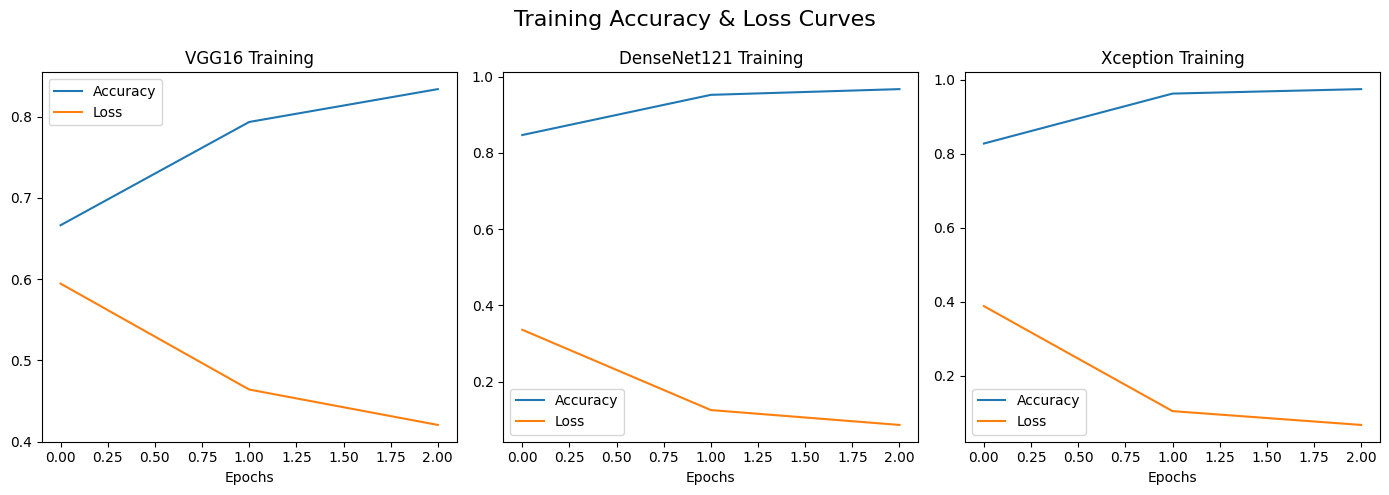

In [24]:
print("\nTraining VGG16...")
vgg = build_vgg()
vgg_history = vgg.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)

print("\nTraining DenseNet121...")
dense = build_dense()
dense_history = dense.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)

print("\nTraining Xception...")
xcep = build_xcep()
xcep_history = xcep.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)
def plot_training_curves(history, name):
    acc_keys = [k for k in history.keys() if "acc" in k or "binary_accuracy" in k]
    acc_key = acc_keys[0] if acc_keys else None

    if acc_key:
        plt.plot(history[acc_key], label="Accuracy")
    else:
        print(f"⚠️ No accuracy key found for {name}. Only plotting loss.")
    
    plt.plot(history["loss"], label="Loss")
    plt.title(f"{name} Training")
    plt.xlabel("Epochs")
    plt.legend()

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plot_training_curves(vgg_history.history, "VGG16")

plt.subplot(1,3,2)
plot_training_curves(dense_history.history, "DenseNet121")

plt.subplot(1,3,3)
plot_training_curves(xcep_history.history, "Xception")

plt.suptitle("Training Accuracy & Loss Curves", fontsize=16)
plt.tight_layout()
plt.show()
